#Lab 2: Reading, Analyzing, and Visualzing Data

As part of the prelab assignment, you went through tutorials on how to use Pandas to read in data, how to use Numpy to analyze (e.g., perform math operations) on data, and how to use Matplotlib to create visualizations of said data. In this lab, we will bring all three of these tools together.

## Culminating Assessment Task: Analyzing Nova Light Curves

Classical novae experience an extremely rapid increase in brightness--hence their name, nova, which is Latin for "New," meaning they are a "New Star" in the sky. They eventually fade back down to their original brightness over some period of time, and the speed with which this decay happens is one measure that astronomers use to classify novae. Specifically, they use a quantity called $t_2$, which is the time it takes a nova to fade by two magnitudes from its maximum brightness. 

For this lab, you will need to plot the light curve of V339 Del, a bright nova that went off in the summer of 2013. Del went off at a very convenient latitude so that both Northern and Southern hemisphere observers could see it. Because of this, Del has *massive* amount of data associated with it. So this is very much a case where you will need to use a computer to analyze the data. 

Along with your plot of the light curve, you will also need to find the date where Del has faded from its maximum by two magnitudes, and put a vertical dashed line on your light curve that shows when this occurred (i.e., at $t_2$). Further, your plot must have informative axes labels, including units as needed. While you should start by analyzing just the V band data, your code should be written in such a way that it is easily extensible to other bands. 




## Input / Output
* __Input:__ A dataframe of observations of V339 Del from the summer of 2013. The data includes dates (in the Julian Date Format), magnitudes (on log scale), uncertainties (in the magnitude), and band type.
* __Output:__ A light curve plot of V339 Del's V Band data with a vertical dashed line at time $t_2$ when Del has faded from its maximum by two magnitudes.

## Design
* Structorgram:


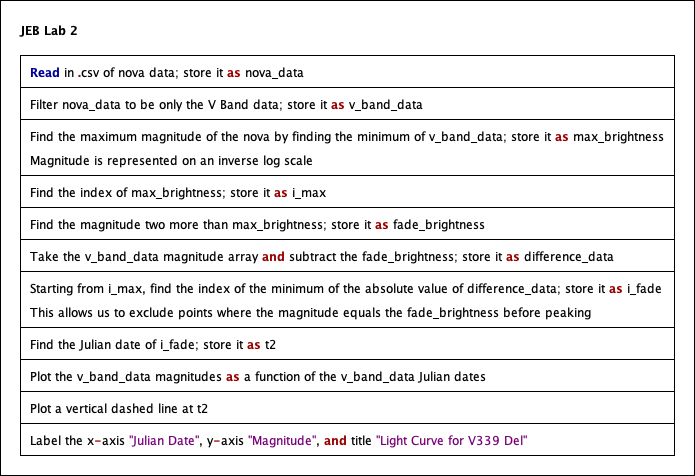

* Variables:
  * `pd` is the pandas library
  * `np` is the numpy library
  * `plt` is the matlibplot library
  * `nova_data` is the input data (read in from `Lab_Data_V339_Del.csv` file)
  * `v_band_data` is only the V Band data from `nova_data`
  * `magnitudes` is an array of the magnitude readings of the `v_band_data`
  * `dates` is an array of the Julian date measurements of the `v_band_data`
  * `max_brightness` is the maximum brightness (minimum magnitude) in `v_band_data`
  * `i_max` is the index in `v_band_data` where `max_brightness` is located
  * `fade_brightness` is the magnitude of the nova after fading from `max_brightness` by two magnitudes
  * `i_fade` is the index in `v_band_data` where `fade_brightness` occurs
  * `difference_data` is a list of the differences between the magnitude observations of `v_band_data` and `fade_brightness`
  * `t2` is the Julian date at index `i_fade`
  * `averaged_magnitudes` is a modified version of `magnitudes`, which has been smoothed out with a rolling average function 
  * `half_window` is the number of data values to the left or right of each value which will be counted by the moving average
  * `window_size` is the total number of datapoints summed up for the rolling average at any one instant
  * `sum_magnitudes` is the sum of the magnitudes within the rolling average window
  * `inst_average` is the instantaneous average corresponding to the current point
* Algorithm Explanation:
  * First, we read in a file containing data about our nova
  * Then, we filter out the v-band data from that information
  * We find the maximum brightness from that v-band data (which should be the minimum of the magnitude, because magnitude uses an inverse log scale)
  * When the nova has 'faded', it's two orders of magnitude dimmer. Each unit of magnitude is an order of magnitude, and because the scale is inverse, increasing the magnitude means decreasing the brightness. So, the brightness of the nova once faded should be its maximum brightness plus 2.
  * Then, we find the value in our v-band data which is closest to the faded brightness, *after* the nova has already reached its max brightness. We do this by subtracting the faded brightness from our list of magnitudes, and finding the index of the value in that list which is closest to 0 (has the smallest difference), starting from `i_max`. If `do_moving_average` is `True`, then the difference data is calculated based on the difference between the averaged magnitudes, instead of the actual magnitudes.
  * `t2` must, then, be the Julian date corresponding to the magnitude we found before (the one closest to the faded brightness), because it's the time when the nova's brightness has faded by two orders of magnitude.
  * Finally, we plot a graph of the magnitudes of the v-band observations against their Julian dates, as well as a dashed vertical line at time `t2`.

## Test
* __I:__ `Lab_Data_V339_Del.csv`
* __O:__ Light curve plot (magnitude vs Julian date) of nova V339 Del with a vetical dashed line at time $t_2$ denoting when Del has faded from its maximum by two magnitudes

Example light curve for V-band data of unnamed nova ![Example light curve for V-band data of unnamed nova](https://www.researchgate.net/profile/David_Joiner/publication/258810460/figure/fig1/AS:669502547165190@1536633254344/Typical-V-bandl-055mm-nova-light-curve-reproduced-from-McLaughlin-McLaughlin.png)

## Implementation

In [ ]:
# This code disects and analyzes the light curve of a given nova. Specifically,
# this code identifies the maximum brightness (and its associated Julian date),
# and the "fade" brightness whose magnitude is two more than the maximum (NOTE: 
# magnitude is measured on an inverse log scale). All of this information is
# then plotted neatly in a light curve graph of magnitude vs. date. We have
# also incorportated options to take the moving average.

# Import libraries needed for array manipulation and plotting.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Find the index of the fade brightness by creating an intermidiate array of
# the magnitudes minus the fade brightness and seeing which is closest to 
# zero. Begins at i_max to exclude data from before the nova reaches max 
# brightness. This function is a sub-function of plot_light_curve
def find_i_fade(fade_brightness, i_max, magnitudes):
  difference_data = abs(magnitudes - fade_brightness)
  i_fade = i_max
  for i in range(i_max, len(difference_data)):
    if difference_data[i] < difference_data[i_fade]:
      i_fade = i
  return i_fade

# Finds the moving average of the magnitudes data by creating a new list of
# averaged magnitude values for a given window size. This is done through a 
# series of for loops after which the data is appended to a list of averaged 
# magnitudes. This function is a sub-function of plot_light curve.
def moving_average(magnitudes, half_window):
  averaged_magnitudes = []
  window_size = 2*half_window + 1
  for i in range(0, half_window):
    averaged_magnitudes.append(float("NaN"))
  for i in range(half_window, len(magnitudes) - half_window):
    sum_magnitudes = sum(magnitudes[i-half_window : i+half_window+1 : 1])
    inst_average = sum_magnitudes/window_size
    averaged_magnitudes.append(inst_average)
  for i in range(0, half_window):
    averaged_magnitudes.append(float("NaN"))
  return np.array(averaged_magnitudes)

def plot_light_curve(name, file, do_moving_average=False, half_window=12):
  # Import nova data.
  nova_data = pd.read_csv(file)
  nova_name = name

  # Filter nova data to be only v band data; break data into two arrays: one 
  # with magnitude data, one with Julian dates.
  v_band_data = nova_data[nova_data["Band"] == "V"]
  magnitudes = np.array(v_band_data["Magnitude"])
  dates = np.array(v_band_data["JD"])

  # Find the index of the maximum brightness (which is the minimum because 
  # magnitude is on an inverse log scale); find the value of the magnitude that
  # is two more than the maximum brightness.
  i_max = np.argmin(magnitudes)
  max_brightness = magnitudes[i_max]
  fade_brightness = max_brightness + 2

  # Decide whether or not to do the moving average
  if do_moving_average:
    averaged_magnitudes = moving_average(magnitudes, half_window)
    i_fade = find_i_fade(fade_brightness, i_max, averaged_magnitudes)
  else:
    i_fade = find_i_fade(fade_brightness, i_max, magnitudes)

  # Find the Julian date associated with the value of the magnitude that is two 
  # more than the maximum brightness.
  t2 = dates[i_fade]

  # Plot the magnitude against the Julian dates and show t2 with a dashed 
  # vertical line. Also consider whether or not to plot the moving average.
  if do_moving_average:
    plt.plot(dates, averaged_magnitudes, "r")
  else:
    plt.plot(dates, magnitudes, "g")
  plt.axvline(x=t2, linestyle="--", color="b", label="t2")
  plt.gca().invert_yaxis()
  plt.title("Light Curve of " + nova_name)
  plt.ylabel("Magnitude")
  plt.xlabel("Julian Date")
  plt.show()

  # Print maximum brightness and "fade" brightness (magnitude at t2)
  print("Brightness at maximum: " + str(max_brightness))
  print("Brightness at t2: " + str(fade_brightness))
  print("t2: " + str(t2))

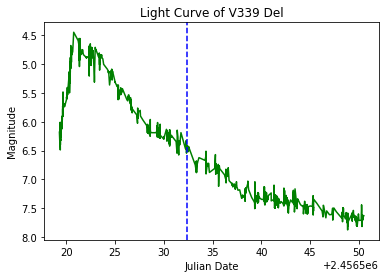

Brightness at maximum: 4.445
Brightness at t2: 6.445
t2: 2456532.356


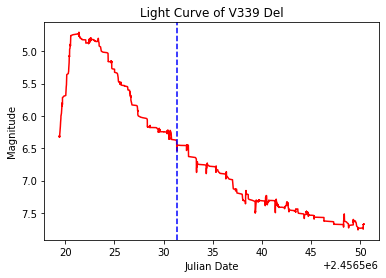

Brightness at maximum: 4.445
Brightness at t2: 6.445
t2: 2456531.328


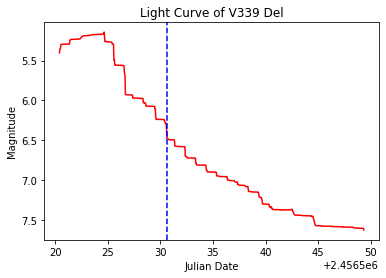

Brightness at maximum: 4.445
Brightness at t2: 6.445
t2: 2456530.608


In [ ]:
# Plot V339 Del light curve

plot_light_curve("V339 Del", "Lab_Data_V339_Del.csv")

plot_light_curve("V339 Del", "Lab_Data_V339_Del.csv", True)

plot_light_curve("V339 Del", "Lab_Data_V339_Del.csv", True, 500)

plot_light_curve("V339 Del", "Lab_Data_V339_Del.csv", True, 500)

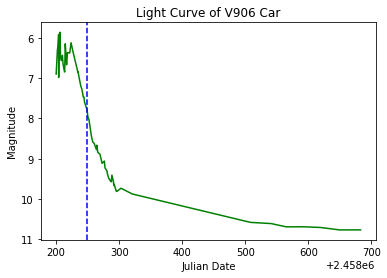

Brightness at maximum: 5.864
Brightness at t2: 7.864
t2: 2458248.986


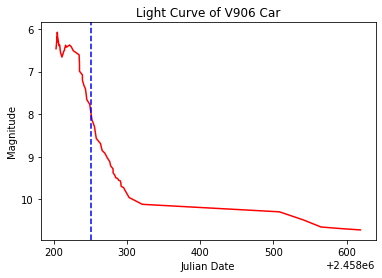

Brightness at maximum: 5.864
Brightness at t2: 7.864
t2: 2458250.496


In [ ]:
# Plot V906 Car light curve

plot_light_curve("V906 Car", "Prelab_Data_V906_Car.csv")

plot_light_curve("V906 Car", "Prelab_Data_V906_Car.csv", True, 2)